# Modelo para a simulação

$$\begin{cases}
dS & = \left(-\beta \cdot S \cdot I +b \cdot (S+R+I) -d \cdot S -b\cdot \frac{(S+R+I)^{2}}{K} +d \cdot \frac{S^{2}}{K} \right)dt + noise_{1} dW\\ 
dI & = \left(\beta \cdot S \cdot I -I \cdot (\gamma + \delta + d) \right )dt + noise_{2} dW\\ 
dR & = \left(\gamma \cdot I -R \cdot(d + f) \right )dt + noise_{3} dW\\ 
dM & = \left(d \cdot (R+S) \right)dt \\ 
dV & = \delta \cdot I dt
\end{cases}$$

## Bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import ipywidgets as widgets
from ipywidgets import interactive
from IPython.display import display

%matplotlib inline

## Parâmetros iniciais

In [2]:
sigma = 5E-9 # desvio padrão
mu = 0. # media
tau = .05 # constante de tempo
T = 6
dt, n = [0.001, int(T / 0.001)]
t = np.linspace(0., T, n)
sigma_bis = sigma * np.sqrt(2. / tau)
sqrtdt = np.sqrt(dt)

## Utils

In [3]:
# Função para escrever os número no formato humano
millnames = ['',' mil',' milhões',' bilhões',' trilhões']
def millify(n):
    n = float(n)
    millidx = max(0,min(len(millnames)-1,
                        int(math.floor(0 if n == 0 else math.log10(abs(n))/3))))

    return '{:3.1f}{}'.format(n / 10**(3 * millidx), millnames[millidx])

# Função para fazer o gráfico de ph
def higiene():
    h = np.linspace(-5,5,50)
    ph = 1./(1+np.exp(h))
    plt.figure(figsize=(12,6))
    plt.plot(h,ph)
    plt.xlabel("Nível de higiene",fontsize=14)
    plt.ylabel("Probabilidade de infecção devido a higiene",fontsize=14)
    plt.grid(True)
    plt.savefig("nivel_higiene.png",dpi=100)
    plt.show()

# Modelo 1 run
def simu(sigma_bis,sqrtdt,beta, b, d, gama,delta,f,S0, K,n):
    nu = b-d
    S = np.zeros(n)
    I = np.zeros(n)
    R = np.zeros(n)
    M = np.zeros(n)
    V = np.zeros(n)
    S[0]=S0
    I[0]=1E-9
    R[0]=0
    M[0]=0
    V[0]=0
    crit_s,crit_i, crit_r = [1.,1.,1.]

    for i in range(n - 1):
        if S[i] <= 0E-9:
            S[i] = 0E-9
            crit_s = 0
        if I[i] <= 0E-9:
            I[i] = 0E-9
            crit_i = 0
        if R[i] <= 0E-9:
            R[i] = 0E-9
            crit_r = 0
        S[i + 1] = S[i] + dt * (-beta*S[i]*I[i] + b*(S[i]+R[i]+I[i]) -d*S[i] - b*(S[i]+I[i]+R[i])**2/K +d*(S[i])**2/K+ f*R[i]) + crit_s*sigma_bis * sqrtdt * np.random.randn()
        I[i + 1] = I[i] + dt * (+beta*S[i+1]*I[i] -gama*I[i] -delta*I[i] -d*I[i])  + crit_i*sigma_bis * sqrtdt * np.random.randn()
        R[i + 1] = R[i] + dt * (+gama*I[i+1] -d*R[i] -f*R[i]) + crit_r*sigma_bis * sqrtdt * np.random.randn()
        M[i + 1] = M[i] + dt * (+d*(R[i+1] +S[i+1]))
        V[i + 1] = V[i] + dt * (+ delta*I[i+1])
    return S,I,R,M,V

# Modelo n runs
def simu_n(steps,beta, b, d, gama, delta, f, S0, K,n):
    S_ = np.zeros(shape=(steps,n))
    I_ = np.zeros(shape=(steps,n))
    R_ = np.zeros(shape=(steps,n))
    M_ = np.zeros(shape=(steps,n))
    V_ = np.zeros(shape=(steps,n))
    for i in range(steps):
        S_[i],I_[i],R_[i],M_[i],V_[i] = simu(sigma_bis,sqrtdt,beta,b,d,gama,delta,f,S0,K,n)
    return S_.mean(axis=0),I_.mean(axis=0),R_.mean(axis=0),M_.mean(axis=0),V_.mean(axis=0)

# função que roda a simulação para um conjunto de parâmetros
def simulation_run(T=12,j=100,h=0,pi=0.5,gama=0.5,delta=0.01,f=0.01,steps=10):
    dt, n = [0.001, int(int(T) / 0.001)]
    t = np.linspace(0., T, n)
    sigma_bis = sigma * np.sqrt(2. / tau)
    sqrtdt = np.sqrt(dt)
    E = j*0.033
    ph = 1./(1+np.exp(h))
    S,I,R,M,V = simu_n(steps=steps,beta=(E*ph*pi), b=0.016, d=0.001, gama=gama, delta=delta, f=f, S0=7.7, K=10,n=int(n))

    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.plot(t, S, '--', label='Suscetível', color="mediumblue",lw=2)
    ax.plot(t, I, '--', label='Infectado',color="orangered",lw=2)
    ax.plot(t, R, '--', label='Recuperado',color="limegreen",lw=2)
    ax.plot(t, S+I+R, '--', label='Total',color="deeppink",lw=2)
    s=f"""
    Em {T} meses\n
    População total: {millify((S[-1]+I[-1]+R[-1])*1E9)}
    População suscetível: {millify(S[-1]*1E9)}
    População infectada: {millify(I[-1]*1E9)}
    População recuperada: {millify(R[-1]*1E9)}
    Mortes totais: {millify((M[-1]+V[-1])*1E9)}
    Mortes naturais: {millify(M[-1]*1E9)}
    Mortes pela doença: {millify(V[-1]*1E9)}\n
    Nível de higiene: {h}
    Prob infecção: {pi:.0%}
    Número médio de inter.: {millify(E/0.033)}\n
    Taxa de cura: {gama:.0%}
    Taxa de mutação: {f:.0%}
    Taxa de mortalidade da doença: {delta:.1%}"""

    ax.legend(bbox_to_anchor=(0.75, 0., 0.5, 1.),fontsize=14)
    ax.text(T*1.09,-0.9, s, fontsize=16)
    ax.set_xlabel("tempo (meses)",fontsize=16)
    ax.set_ylabel("População (bilhões)",fontsize=16)
    ax.grid(True)

# Roda a simulação interativa    
def interactive_simulation():
    T = widgets.IntText(description='Período de tempo:', value=6,continuous_update=True)
    j = widgets.FloatText(description='Interação:', value=100, continuous_update=True)
    h = widgets.FloatText(description='Nível de higiene:', value=0, continuous_update=True)
    pi = widgets.FloatText(description='Prob. infecção:', value=0.3, continuous_update=True)
    gama = widgets.FloatText(description='Taxa cura:', value=0.8, continuous_update=True)
    delta = widgets.FloatText(description='Letalidade:', value=0.035, continuous_update=True)
    f = widgets.FloatText(description='Taxa mutação:', value=0.01, continuous_update=True)
    steps = widgets.IntText(description='num. simulações:', value=20, continuous_update=True)
    out = widgets.interactive_output(simulation_run, {"T":T,
                                                    "j":j,
                                                    "h":h,
                                                    "pi":pi,
                                                    "gama":gama,
                                                    "delta":delta,
                                                    "f":f,
                                                    "steps":steps})
    T.layout.width, j.layout.width, h.layout.width = ['200px','200px','200px']
    pi.layout.width, gama.layout.width,delta.layout.width, f.layout.width = ["200px","200px","200px","200px"]
    steps.layout.width = '200px'
    display(widgets.HBox([T,j,h]),widgets.HBox([pi,gama,delta,f,steps]),out)

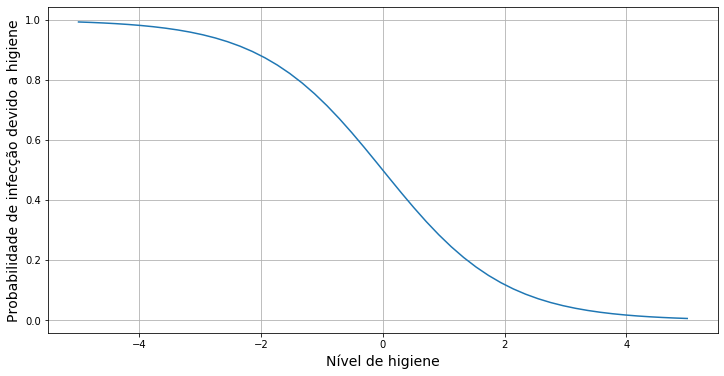

In [4]:
# Visualiza a curva de ph
higiene()

## Simulações

CPU times: user 27.8 s, sys: 92.3 ms, total: 27.9 s
Wall time: 27.9 s


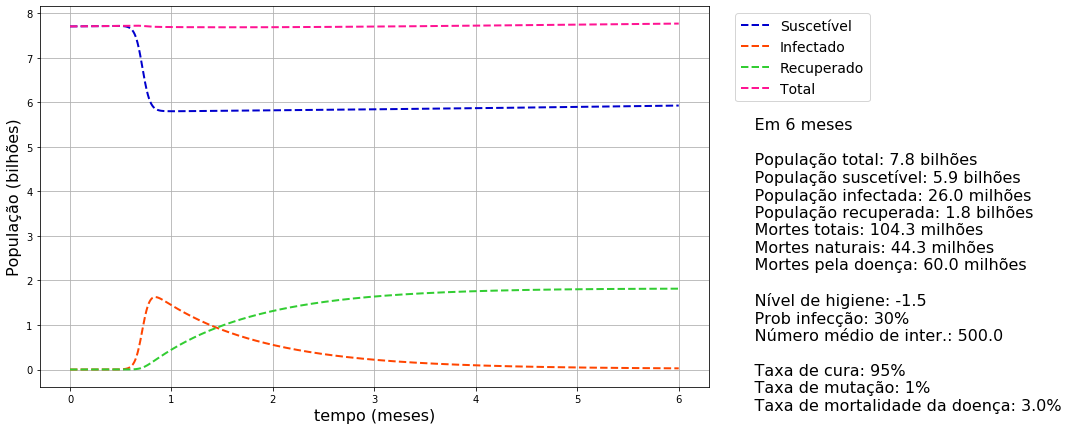

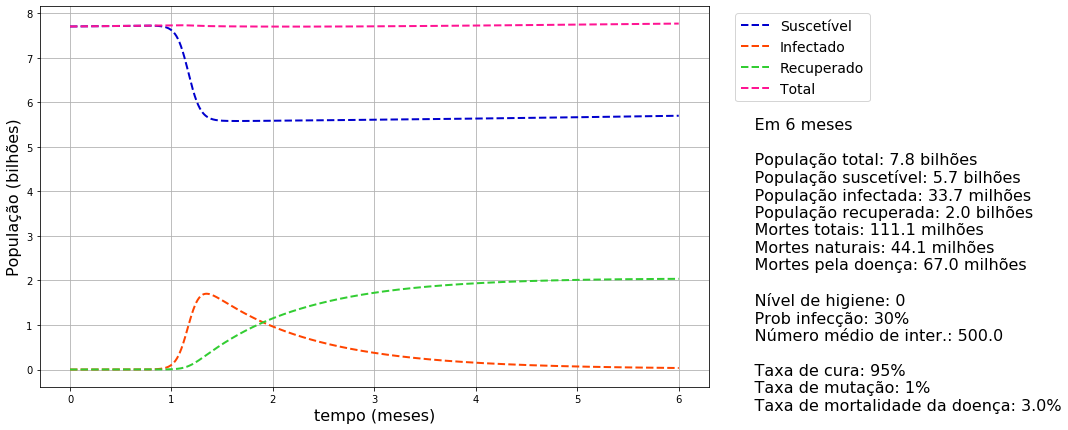

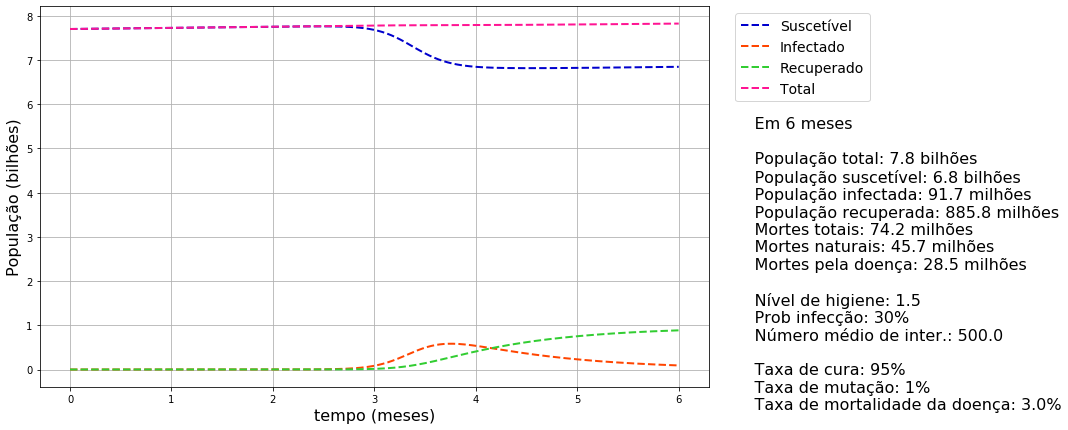

In [5]:
%%time
# testando higiene
for h in (-1.5,0,1.5):
    E,pi = [500*0.033,0.3]
    gama,delta,f = [0.95,0.03,0.01]
    ph = 1./(1+np.exp(h))
    S,I,R,M,V = simu_n(steps=200,beta=(E*ph*pi), b=0.016, d=0.001, gama=gama, delta=delta, f=f, S0=7.7, K=10,n=n)

    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.plot(t, S, '--', label='Suscetível', color="mediumblue",lw=2)
    ax.plot(t, I, '--', label='Infectado',color="orangered",lw=2)
    ax.plot(t, R, '--', label='Recuperado',color="limegreen",lw=2)
    ax.plot(t, S+I+R, '--', label='Total',color="deeppink",lw=2)
    s=f"""
    Em {T} meses\n
    População total: {millify((S[-1]+I[-1]+R[-1])*1E9)}
    População suscetível: {millify(S[-1]*1E9)}
    População infectada: {millify(I[-1]*1E9)}
    População recuperada: {millify(R[-1]*1E9)}
    Mortes totais: {millify((M[-1]+V[-1])*1E9)}
    Mortes naturais: {millify(M[-1]*1E9)}
    Mortes pela doença: {millify(V[-1]*1E9)}\n
    Nível de higiene: {h}
    Prob infecção: {pi:.0%}
    Número médio de inter.: {millify(E/0.033)}\n
    Taxa de cura: {gama:.0%}
    Taxa de mutação: {f:.0%}
    Taxa de mortalidade da doença: {delta:.1%}"""

    ax.legend(bbox_to_anchor=(0.75, 0., 0.5, 1.),fontsize=14)
    ax.text(T*1.09,-0.9, s, fontsize=16)
    ax.set_xlabel("tempo (meses)",fontsize=16)
    ax.set_ylabel("População (bilhões)",fontsize=16)
    ax.grid(True)
    plt.savefig(f"fig_higiene_{h}.png", bbox_inches='tight',dpi=150)

CPU times: user 27 s, sys: 80.3 ms, total: 27.1 s
Wall time: 27.1 s


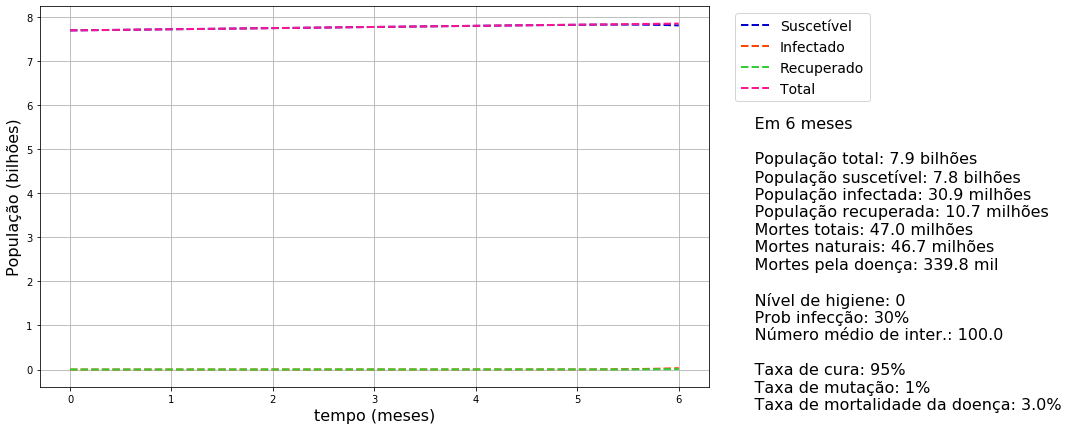

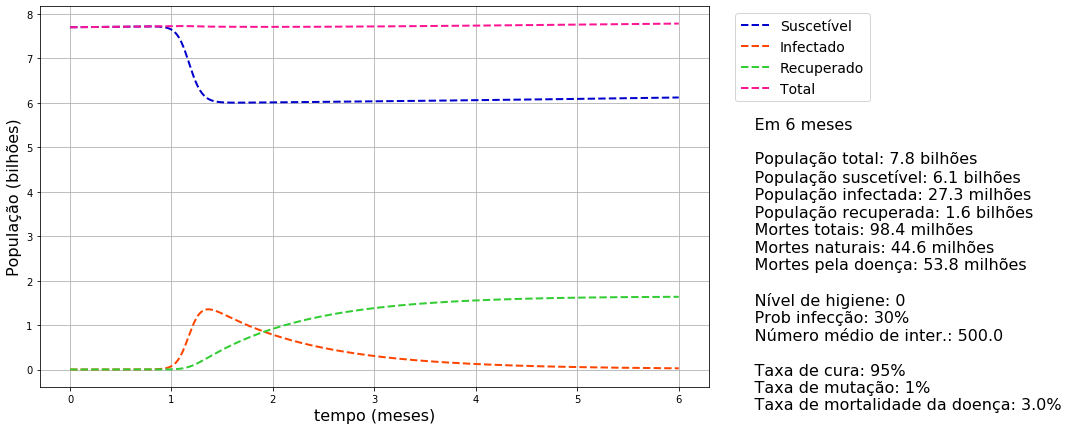

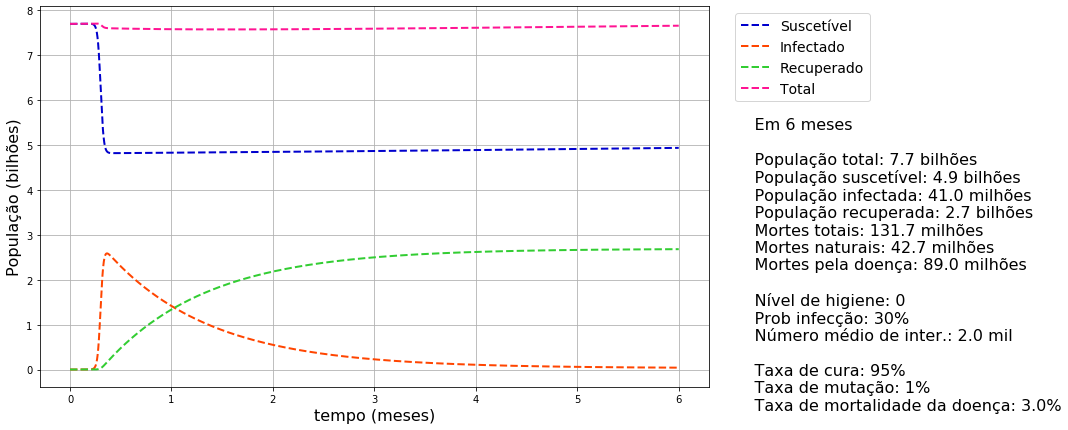

In [6]:
%%time
# testando Interação
T = 6
dt, n = [0.001, int(T / 0.001)]
t = np.linspace(0., T, n)
sigma_bis = sigma * np.sqrt(2. / tau)
sqrtdt = np.sqrt(dt)
for j in (100,500,2000):
    E,pi = [j*0.033,0.3]
    h = 0
    gama,delta,f = [0.95,0.03,0.01]
    ph = 1./(1+np.exp(h))
    S,I,R,M,V = simu_n(steps=200,beta=(E*ph*pi), b=0.016, d=0.001, gama=gama, delta=delta, f=f, S0=7.7, K=10,n=n)

    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.plot(t, S, '--', label='Suscetível', color="mediumblue",lw=2)
    ax.plot(t, I, '--', label='Infectado',color="orangered",lw=2)
    ax.plot(t, R, '--', label='Recuperado',color="limegreen",lw=2)
    ax.plot(t, S+I+R, '--', label='Total',color="deeppink",lw=2)
    s=f"""
    Em {T} meses\n
    População total: {millify((S[-1]+I[-1]+R[-1])*1E9)}
    População suscetível: {millify(S[-1]*1E9)}
    População infectada: {millify(I[-1]*1E9)}
    População recuperada: {millify(R[-1]*1E9)}
    Mortes totais: {millify((M[-1]+V[-1])*1E9)}
    Mortes naturais: {millify(M[-1]*1E9)}
    Mortes pela doença: {millify(V[-1]*1E9)}\n
    Nível de higiene: {h}
    Prob infecção: {pi:.0%}
    Número médio de inter.: {millify(E/0.033)}\n
    Taxa de cura: {gama:.0%}
    Taxa de mutação: {f:.0%}
    Taxa de mortalidade da doença: {delta:.1%}"""
    ax.legend(bbox_to_anchor=(0.75, 0., 0.5, 1.),fontsize=14)
    ax.text(T*1.09,-0.9, s, fontsize=16)
    ax.set_xlabel("tempo (meses)",fontsize=16)
    ax.set_ylabel("População (bilhões)",fontsize=16)
    ax.grid(True)
    plt.savefig(f"fig_E_{int(E/0.033)}.png", bbox_inches='tight',dpi=150)

CPU times: user 53.2 s, sys: 140 ms, total: 53.3 s
Wall time: 53.3 s


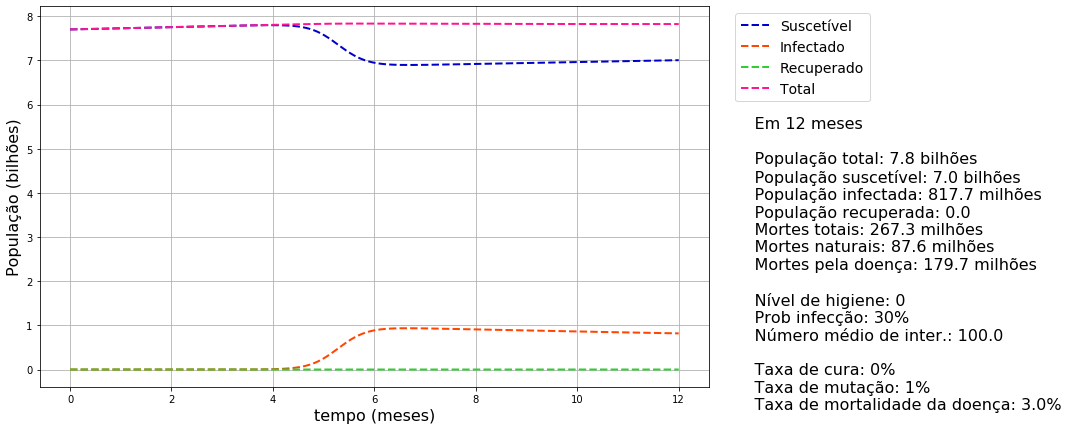

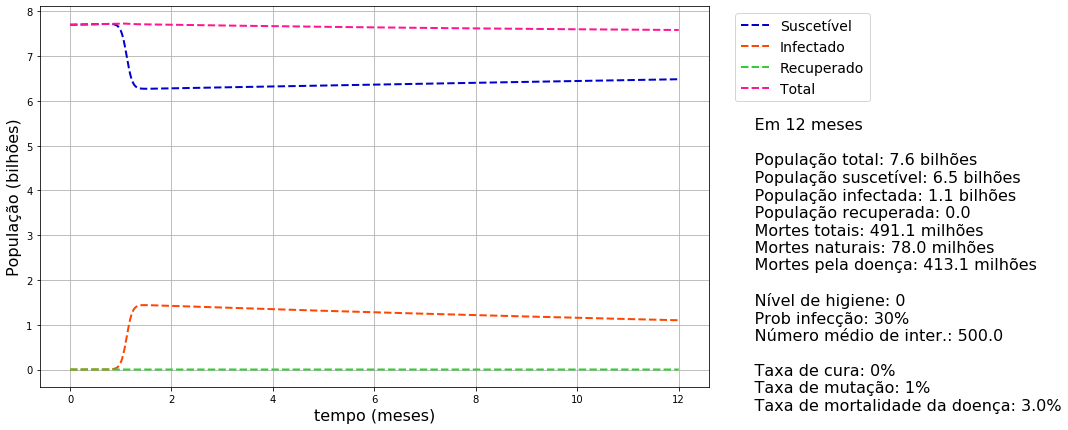

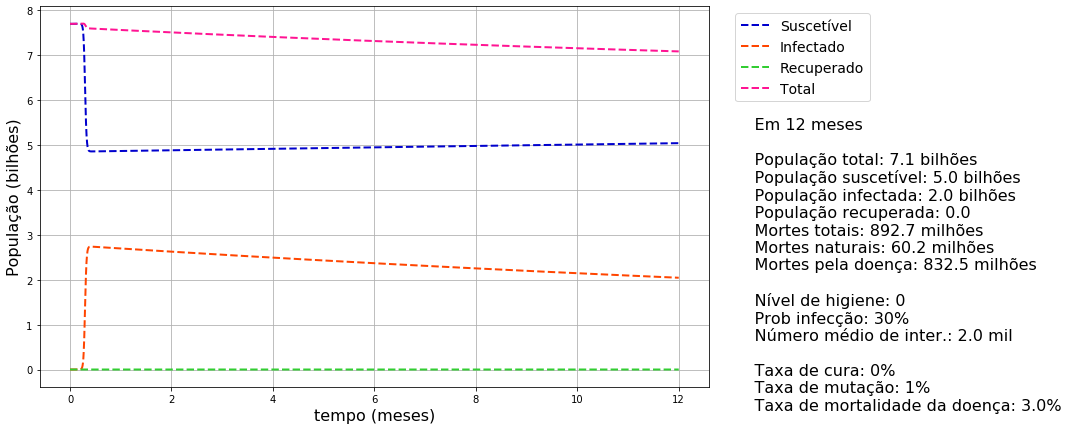

In [7]:
%%time
# doença sem cura
T = 12
dt, n = [0.001, int(T / 0.001)]
t = np.linspace(0., T, n)
sigma_bis = sigma * np.sqrt(2. / tau)
sqrtdt = np.sqrt(dt)
for j in (100,500,2000):
    E,pi = [j*0.033,0.3]
    h = 0
    gama,delta,f = [0.0,0.03,0.01]
    ph = 1./(1+np.exp(h))
    S,I,R,M,V = simu_n(steps=200,beta=(E*ph*pi), b=0.016, d=0.001, gama=gama, delta=delta, f=f, S0=7.7, K=10,n=n)

    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    ax.plot(t, S, '--', label='Suscetível', color="mediumblue",lw=2)
    ax.plot(t, I, '--', label='Infectado',color="orangered",lw=2)
    ax.plot(t, R, '--', label='Recuperado',color="limegreen",lw=2)
    ax.plot(t, S+I+R, '--', label='Total',color="deeppink",lw=2)
    s=f"""
    Em {T} meses\n
    População total: {millify((S[-1]+I[-1]+R[-1])*1E9)}
    População suscetível: {millify(S[-1]*1E9)}
    População infectada: {millify(I[-1]*1E9)}
    População recuperada: {millify(R[-1]*1E9)}
    Mortes totais: {millify((M[-1]+V[-1])*1E9)}
    Mortes naturais: {millify(M[-1]*1E9)}
    Mortes pela doença: {millify(V[-1]*1E9)}\n
    Nível de higiene: {h}
    Prob infecção: {pi:.0%}
    Número médio de inter.: {millify(E/0.033)}\n
    Taxa de cura: {gama:.0%}
    Taxa de mutação: {f:.0%}
    Taxa de mortalidade da doença: {delta:.1%}"""
    ax.legend(bbox_to_anchor=(0.75, 0., 0.5, 1.),fontsize=14)
    ax.text(T*1.09,-0.9, s, fontsize=16)
    ax.set_xlabel("tempo (meses)",fontsize=16)
    ax.set_ylabel("População (bilhões)",fontsize=16)
    ax.grid(True)
    plt.savefig(f"fig_semcura_E_{int(E/0.033)}.png", bbox_inches='tight',dpi=150)

CPU times: user 892 ms, sys: 42 µs, total: 892 ms
Wall time: 891 ms


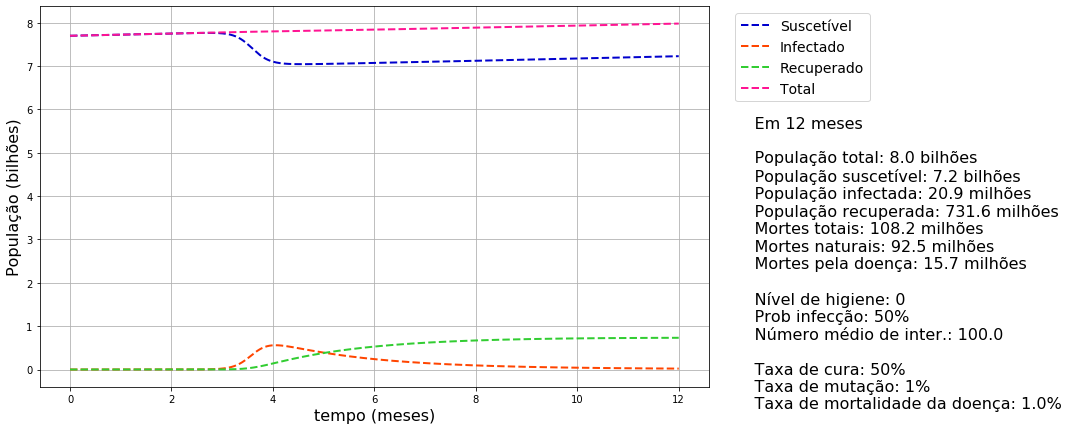

In [8]:
%%time
# Roda simulação na mão
simulation_run(T=12,j=100,h=0,pi=0.5,gama=0.5,delta=0.01,f=0.01,steps=10)

In [9]:
# Roda simulação interativa
interactive_simulation()

Output()

### Verificar sensibilidade à perturbações

In [10]:
def deltas(E,h,pi):
    delta_dbdE = (pi/(1+np.exp(h)))*0.1*E
    delta_dbdh = (-E*pi*np.exp(h)/(1+np.exp(h)**2))*0.1*h
    delta_dbdpi = (E/(1+np.exp(h)))*0.1*pi
    return delta_dbdE, delta_dbdh, delta_dbdpi

In [11]:
E_list = [100, 200, 1000]
h_list = [-2,0,2]
pi_list= [0.05,0.1,0.2]
for E in E_list:
    for h in h_list:
        for pi in pi_list:
            delta_dbdE, delta_dbdh, delta_dbdpi = deltas(E,h,pi)
            print(f"E:{E}, h:{h}, pi:{pi}")
            print(f"delta_dbdE: {delta_dbdE:.1f}, delta_dbdh: {delta_dbdh:.1f}, delta_dbdpi: {delta_dbdpi:.1f}")

E:100, h:-2, pi:0.05
delta_dbdE: 0.4, delta_dbdh: 0.1, delta_dbdpi: 0.4
E:100, h:-2, pi:0.1
delta_dbdE: 0.9, delta_dbdh: 0.3, delta_dbdpi: 0.9
E:100, h:-2, pi:0.2
delta_dbdE: 1.8, delta_dbdh: 0.5, delta_dbdpi: 1.8
E:100, h:0, pi:0.05
delta_dbdE: 0.3, delta_dbdh: -0.0, delta_dbdpi: 0.2
E:100, h:0, pi:0.1
delta_dbdE: 0.5, delta_dbdh: -0.0, delta_dbdpi: 0.5
E:100, h:0, pi:0.2
delta_dbdE: 1.0, delta_dbdh: -0.0, delta_dbdpi: 1.0
E:100, h:2, pi:0.05
delta_dbdE: 0.1, delta_dbdh: -0.1, delta_dbdpi: 0.1
E:100, h:2, pi:0.1
delta_dbdE: 0.1, delta_dbdh: -0.3, delta_dbdpi: 0.1
E:100, h:2, pi:0.2
delta_dbdE: 0.2, delta_dbdh: -0.5, delta_dbdpi: 0.2
E:200, h:-2, pi:0.05
delta_dbdE: 0.9, delta_dbdh: 0.3, delta_dbdpi: 0.9
E:200, h:-2, pi:0.1
delta_dbdE: 1.8, delta_dbdh: 0.5, delta_dbdpi: 1.8
E:200, h:-2, pi:0.2
delta_dbdE: 3.5, delta_dbdh: 1.1, delta_dbdpi: 3.5
E:200, h:0, pi:0.05
delta_dbdE: 0.5, delta_dbdh: -0.0, delta_dbdpi: 0.5
E:200, h:0, pi:0.1
delta_dbdE: 1.0, delta_dbdh: -0.0, delta_dbdpi: 1.0
E